**Check GPU availability**

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Mount Google drive**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dependencies**

In [8]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
# from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras
import random

import warnings
warnings.filterwarnings('ignore')

In [9]:
import os
import random
from IPython.display import Image, display
import cv2
import PIL
from PIL import ImageOps
from matplotlib import pyplot as plt

import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dropout, Lambda

**Data Analysis**

In [ ]:
# Number of files in training input and output folders

data_path = '/content/drive/MyDrive/roads_dataset'
input_dir = os.path.join(data_path, 'training', 'IMAGES')
target_dir = os.path.join(data_path, 'training', 'MASKS')

n_input_train = len(os.listdir(input_dir))
print(f'TRAIN Input has {n_input_train} images')

n_output_train = len(os.listdir(target_dir))
print(f'TRAIN Output has {n_output_train} images')

TRAIN Input has 20644 images
TRAIN Output has 20503 images


We had 20503 images and 20503 masks on local, but after copying to Google drive I found IMAGES folder has 20644 images. Some unknown issue. Fatser way to solve this is: compare images and masks and remove the ones extra.

In [ ]:
count = 0
for im in os.listdir(input_dir):
  if im not in os.listdir(target_dir):
    count += 1
    print(im)
    if count == 5:
      break

img-959_16 (1).png
img-959_15 (1).png
img-983_9 (1).png
img-983_6 (1).png
img-983_7 (1).png


Looks like some file got duplicated while copying to Gdrive. These filenames end with "(1)".

Comparing files among IMAGES and MASKS folder is very costly calculation and might not complete easily in Colab environment.

In [ ]:
dup_images = []
for im in os.listdir(input_dir):
  if im.split('.')[0].endswith(')'):
    dup_images.append(im)
print(f'{len(dup_images)} images got duplicated')

141 images got duplicated


In [ ]:
dup_images[:5]

['img-959_16 (1).png',
 'img-959_15 (1).png',
 'img-983_9 (1).png',
 'img-983_6 (1).png',
 'img-983_7 (1).png']

This matches with the Number 20644 - 20503 = 141. So, we can safely remove these dup images.

In [ ]:
for im in dup_images:
  os.remove(os.path.join(input_dir, im))

**Check duplicates in the testing dir**

In [ ]:
dup_test_images = []
for im in os.listdir(test_input_dir):
  if im.split('.')[0].endswith(')'):
    dup_test_images.append(im)
print(f'{len(dup_test_images)} images got duplicated')

9 images got duplicated


In [ ]:
for im in dup_test_images:
  os.remove(os.path.join(test_input_dir, im))

In [48]:
dup_test_masks = []
for im in os.listdir(test_target_dir):
  if im.split('.')[0].endswith(')'):
    dup_test_masks.append(im)
print(f'{len(dup_test_masks)} masks got duplicated')

10 masks got duplicated


In [49]:
for im in dup_test_masks:
  os.remove(os.path.join(test_target_dir, im))

**Duplicate train masks**

In [ ]:
dup_train_masks = []
for im in os.listdir(target_dir):
  if im.split('.')[0].endswith(')'):
    dup_train_masks.append(im)
print(f'{len(dup_train_masks)} train masks got duplicated')

507 train masks got duplicated


In [ ]:
for im in dup_train_masks:
  os.remove(os.path.join(target_dir, im))

**Data Validation**

In [10]:
# Number of files in training input and output folders

data_path = '/content/drive/MyDrive/roads_dataset'
input_dir = os.path.join(data_path, 'training', 'IMAGES')
target_dir = os.path.join(data_path, 'training', 'MASKS')

n_input_train = len(os.listdir(input_dir))
print(f'TRAIN Input (IMAGES) has {n_input_train} images')

n_output_train = len(os.listdir(target_dir))
print(f'TRAIN Output (MASKS) has {n_output_train} images')

TRAIN Input (IMAGES) has 20503 images
TRAIN Output (MASKS) has 20503 images


In [12]:
# Train data sanity check
## Running this block everytime a randomly chosen image and its corr mask will appear
random_image_file = random.choice(os.listdir(input_dir))

random_image = cv2.imread(os.path.join(input_dir, random_image_file))
random_mask = cv2.imread(os.path.join(target_dir, random_image_file))
print(random_image_file, random_image.shape)
print(random_image_file, random_mask.shape)

img-497_3.png (256, 256, 3)
img-497_3.png (256, 256, 3)


**Number of Test Images and Masks**

In [13]:
test_input_dir = os.path.join(data_path,'testing','IMAGES')
test_target_dir = os.path.join(data_path,'testing','MASKS')

In [14]:
assert len(os.listdir(test_input_dir))==len(os.listdir(test_target_dir))
print(f'Number of test images = {len(os.listdir(test_input_dir))}')

Number of test images = 468


**Resize all images to (256, 256)**

In [ ]:
def resize_img(img_dir, grayscale=False):
    count = 0
    file_list = os.listdir(img_dir)
    for im in file_list:
        if grayscale:
            img = cv2.imread(os.path.join(img_dir, im), 0)
        else:
            img = cv2.imread(os.path.join(img_dir, im))
        img1 = cv2.resize(img, (256,256))
        os.remove(os.path.join(img_dir, im))
        cv2.imwrite(os.path.join(img_dir, im), img1)
        count += 1
        if count%1000==0:
            print(f'{count} images resized')
    print(f'{count} done')

In [ ]:
resize_img(test_input_dir)

402 done


In [ ]:
resize_img(test_target_dir, grayscale=True)

393 done


In [ ]:
# Test data sanity check
## Running this block everytime a randomly chosen image and its corr mask will appear

random_image_file = random.choice(os.listdir(test_input_dir))

random_image = cv2.imread(os.path.join(test_input_dir, random_image_file))
random_mask = cv2.imread(os.path.join(test_target_dir, random_image_file), 0)
print(random_image_file, random_image.shape)
print(random_image_file, random_mask.shape)

img-9_6.png (256, 256, 3)
img-9_6.png (256, 256)


**Resizing Images took significant amount of time on Colab**

In [ ]:
%%time
resize_img(input_dir)

1000 images resized
2000 images resized
3000 images resized
4000 images resized
5000 images resized
6000 images resized
7000 images resized
8000 images resized
9000 images resized
10000 images resized
11000 images resized
12000 images resized
13000 images resized
14000 images resized
15000 images resized
16000 images resized
17000 images resized
18000 images resized
19000 images resized
20000 images resized
20503 done
CPU times: user 2min 55s, sys: 25.6 s, total: 3min 21s
Wall time: 3h 57min 27s


**Data Validation**

In [11]:
# Train data sanity check
## Running this block everytime randomly chosen images and their corr mask will appear

images = sorted(os.listdir(input_dir))
masks = sorted(os.listdir(target_dir))
random_ind = random.choices(range(len(images)), k=10)
print(random_ind)
for r in random_ind:
    random_image = cv2.imread(os.path.join(input_dir, images[r]))
    random_mask = cv2.imread(os.path.join(target_dir, masks[r]), 0)
    print(images[r], random_image.shape, ' | ', masks[r], random_mask.shape)

[5246, 7748, 1506, 2971, 18233, 8267, 1055, 12685, 8226, 19212]
img-305_28.png (256, 256, 3)  |  img-305_28.png (256, 256)
img-457_11.png (256, 256, 3)  |  img-457_11.png (256, 256)
img-109_20.png (256, 256, 3)  |  img-109_20.png (256, 256)
img-162_9.png (256, 256, 3)  |  img-162_9.png (256, 256)
img-900_18.png (256, 256, 3)  |  img-900_18.png (256, 256)
img-478_23.png (256, 256, 3)  |  img-478_23.png (256, 256)
img-106_30.png (256, 256, 3)  |  img-106_30.png (256, 256)
img-667_12.png (256, 256, 3)  |  img-667_12.png (256, 256)
img-477_10.png (256, 256, 3)  |  img-477_10.png (256, 256)
img-950_1.png (256, 256, 3)  |  img-950_1.png (256, 256)


**Visualize Imgaes and Masks**

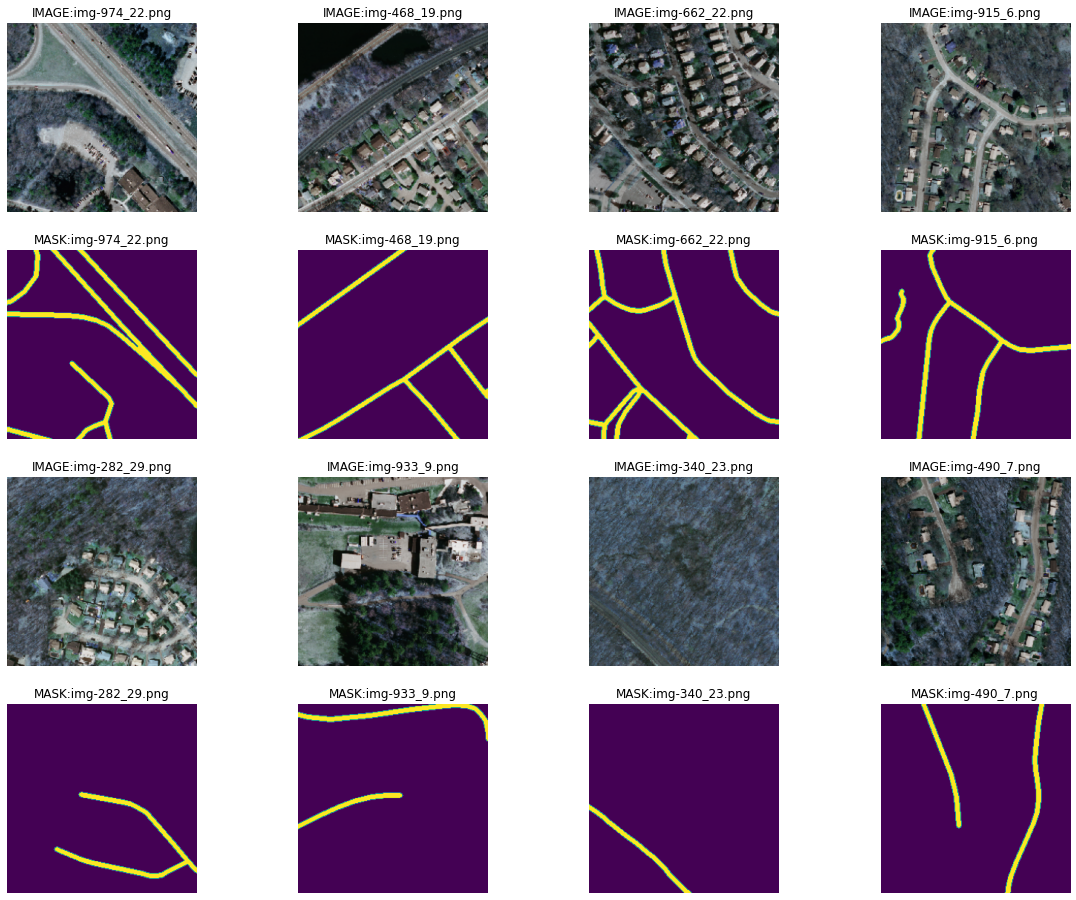

In [7]:
plt.figure(figsize=(20,16))
x, y = 4, 2
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        random_image_file = random.choice(os.listdir(input_dir))
        img = cv2.imread(os.path.join(input_dir, random_image_file))
        plt.imshow(img)
        plt.title(f'IMAGE:{os.path.basename(random_image_file)}')
        plt.axis('off')

        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        msk = cv2.imread(os.path.join(target_dir, random_image_file), 0)
        plt.imshow(msk)
        plt.title(f'MASK:{os.path.basename(random_image_file)}')
        plt.axis('off')
plt.show()

In [15]:
# Images and Mask paths creation and quick data sanity check

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.png')])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png')])

print("Number of train images:", len(input_img_paths))
print("Number of train masks:", len(target_img_paths))

# Print 10 randomly chosen image filenames and their corresponding masks filenames
r_ind = random.choices(range(20000), k=10)
for input_path, target_path in zip([input_img_paths[r] for r in r_ind], [target_img_paths[r] for r in r_ind]):
    print(input_path, "|", target_path)

Number of train images: 20503
Number of train masks: 20503
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-396_2.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-396_2.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-568_8.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-568_8.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-222_8.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-222_8.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-744_14.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-744_14.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-1043_5.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-1043_5.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-140_25.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-140_25.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-282_2.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-

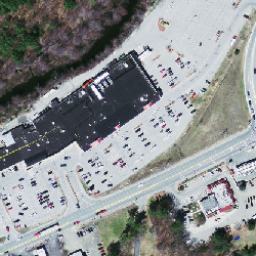

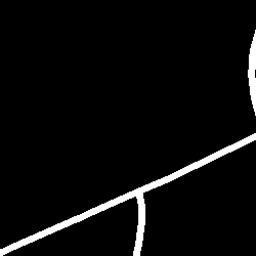

In [47]:
# Display a random input image
display(Image(filename=input_img_paths[r_ind[0]]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[r_ind[0]]))
display(img)

**Training Data Preparation**

**Data generator class**

In [16]:
class data_generator(keras.utils.Sequence):
    """Data generator - iterates over the data"""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch idx"""
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)/255
        return x, y

In [19]:
img_size = (256, 256)
num_classes = 2
batch_size = 16

**Split image paths into a training and validation sets**

In [20]:
# 10% validation set
val_ratio = 0.1
val_samples = int(val_ratio * n_input_train)

# Random shuffle input and target with same seed
random.Random(100).shuffle(input_img_paths)
random.Random(100).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = data_generator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = data_generator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

**Check shapes of input and output images**

In [21]:
print('Train image: ', train_gen[0][0].shape, 'Train mask: ', train_gen[0][1].shape)
print('Val image: ', val_gen[0][0].shape, 'Val mask: ',  val_gen[0][1].shape)

Train image:  (16, 256, 256, 3) Train mask:  (16, 256, 256, 1)
Val image:  (16, 256, 256, 3) Val mask:  (16, 256, 256, 1)


In [18]:
# masks are normalized during data ganaration

print(np.unique(train_gen[100][1]))
print(np.unique(train_gen[100][0]))

[0 1]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.


**Define U-Net Model**

In [43]:
def get_model(img_size):
    inputs = keras.Input(shape=img_size + (3,))
    s = Lambda(lambda x: x / 255) (inputs)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(16, 3, strides=2, padding="same")(s)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("elu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3, 4 are identical apart from the feature depth.
    for filters in [32, 64, 128, 256]:
        x = layers.Activation("elu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Activation("elu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32, 16]:
        x = layers.Activation("elu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Activation("elu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

    # Define the model
    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
______________________________________________________________________________________________

**Model Training**

In [21]:
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Model saved with name: road_unet_x -> where x denote training id

Incremental training: loading previously trained model continues training for more epoch. This is necessary as Colab runtime disconnects for longer GPU usage.

In [24]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [44]:
# For initial training

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_coef])

model_path = '/content/drive/MyDrive/roads_dataset/models/road_unet_final_2.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_iou_coef", mode="max", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4)

In [25]:
## For Incremental training

model = load_model('/content/drive/MyDrive/roads_dataset/models/road_unet_final_2.h5', custom_objects={'iou_coef': iou_coef})

In [36]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_coef])

In [42]:
model_path = '/content/drive/MyDrive/roads_dataset/models/road_unet_final2.h5'

checkpoint = ModelCheckpoint(model_path, monitor="val_iou_coef", mode="max", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4)

In [45]:
epochs = 100
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=val_gen,
                    callbacks = [checkpoint])

Epoch 1/100
1153/1153 [==============================] - 12774s 11s/step - loss: 0.1663 - iou_coef: 0.1485 - val_loss: 0.1314 - val_iou_coef: 0.2675

Epoch 00001: val_iou_coef improved from -inf to 0.26750, saving model to /content/drive/MyDrive/roads_dataset/models/road_unet_final_2.h5
Epoch 2/100
1153/1153 [==============================] - 165s 143ms/step - loss: 0.1182 - iou_coef: 0.2747 - val_loss: 0.1304 - val_iou_coef: 0.2954

Epoch 00002: val_iou_coef improved from 0.26750 to 0.29541, saving model to /content/drive/MyDrive/roads_dataset/models/road_unet_final_2.h5
Epoch 3/100
1153/1153 [==============================] - 163s 141ms/step - loss: 0.1100 - iou_coef: 0.3061 - val_loss: 0.1103 - val_iou_coef: 0.3485

Epoch 00003: val_iou_coef improved from 0.29541 to 0.34849, saving model to /content/drive/MyDrive/roads_dataset/models/road_unet_final_2.h5
Epoch 4/100
1153/1153 [==============================] - 164s 142ms/step - loss: 0.1060 - iou_coef: 0.3220 - val_loss: 0.1106 - va

**Prediction on Test Data**

In [26]:
test_input_img_paths = sorted([os.path.join(test_input_dir, fname) for fname in os.listdir(test_input_dir) if fname.endswith('.png')])
test_target_img_paths = sorted([os.path.join(test_target_dir, fname) for fname in os.listdir(test_target_dir) if fname.endswith('.png')])

In [27]:
test_img_names = [os.path.basename(fname) for fname in test_input_img_paths]
len(test_img_names)

468

In [28]:
len(test_input_img_paths), len(test_target_img_paths)

(468, 468)

**Visualize Predictions**

In [29]:
test_images = np.array([cv2.imread(test_input_img_paths[i]) for i in range(len(test_input_img_paths))])
test_masks = np.array([cv2.imread(test_target_img_paths[i],0) for i in range(len(test_target_img_paths))])

In [30]:
test_images.shape, test_masks.shape

((468, 256, 256, 3), (468, 256, 256))

In [31]:
test_preds = model.predict(test_images)

In [32]:
test_preds_thresh = (test_preds >= 0.1).astype(np.uint8)
len(test_preds_thresh)

468

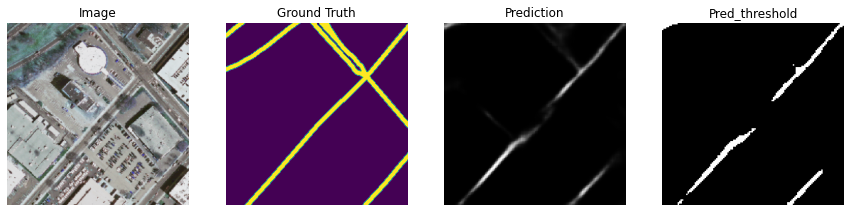

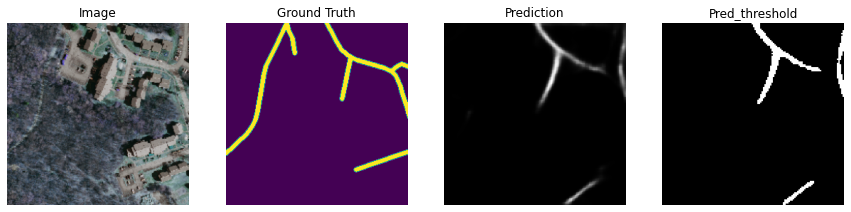

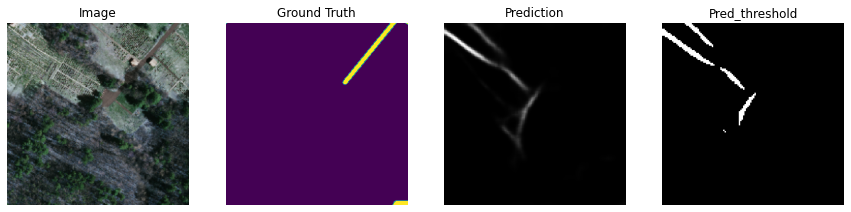

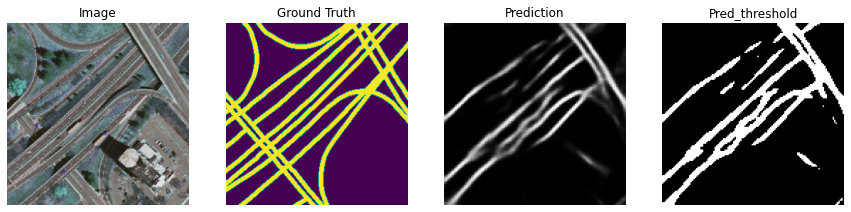

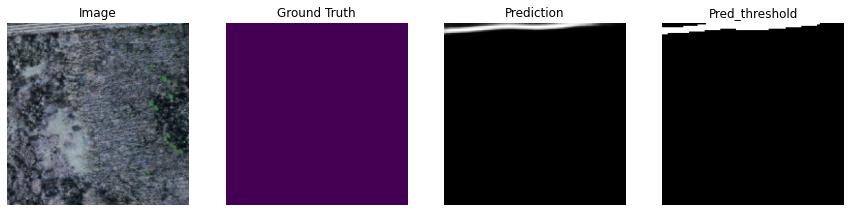

In [34]:
test_preds_thresh = (test_preds >= 0.2).astype(np.uint8)
for _ in range(5):
    i = random.choice(range(len(test_preds)))
    plt.figure(figsize = (15, 12))

    plt.subplot(141)
    img = test_images[i]
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(142)
    msk = test_masks[i]
    plt.imshow(msk)
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(143)
    p = test_preds[i]
    plt.imshow(p[:,:,0], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.subplot(144)
    p1 = test_preds_thresh[i]
    plt.imshow(p1[:,:,0], cmap='gray')
    plt.title("Pred_threshold")
    plt.axis('off')

    plt.show()

**Save predicted masks on drive**

In [35]:
pred_path = '/content/drive/MyDrive/roads_dataset/testing/predictions'
for i, pred in enumerate(test_preds_thresh):
    cv2.imwrite(os.path.join(pred_path, test_img_names[i]), pred[:,:,0]*255)

In [1]:
def plot_training(history):

  train_iou = history['iou_coef']
  val_iou = history['val_iou_coef']
  train_loss = history['loss']
  val_loss = history['val_loss']
  epoch_range = range(len(train_iou))

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_range, train_iou, label='Training IoU')
  plt.plot(epoch_range, val_iou, label='Validation IoU')
  plt.title('IoU')
  plt.legend(loc='lower right')

  # plt.subplot(1, 2, 2)
  plt.plot(epoch_range, train_loss, label='Training Loss')
  plt.plot(epoch_range, val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.legend(loc='upper right')
  plt.show()

In [2]:
plot_training(history.history)

NameError: ignored

In [3]:
# history.history

**Accuracy Metrics**

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

def compute_iou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    c_mat = confusion_matrix(y_true, y_pred, labels=[1, 0])
    intersection = np.diag(c_mat)
    ground_truth_set = c_mat.sum(axis=1)
    predicted_set = c_mat.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    mean_IoU = round(np.mean([i for i in IoU if i==i]), 2)
    acc = round(accuracy_score(y_true, y_pred), 2)
    prec = round(precision_score(y_true, y_pred, average='macro'), 2)
    rec = round(recall_score(y_true, y_pred, average='macro'), 2)
    return mean_IoU, acc, prec, rec

In [39]:
# np.unique(test_masks[0])

In [38]:
# binarize test masks

test_masks_binary = (test_masks >= 50).astype(np.uint8)
np.unique(test_masks_binary[0])

array([0, 1], dtype=uint8)

**Calculate and print accuracy metric scores**

In [41]:
scores = [compute_iou(test_preds_thresh[i], test_masks_binary[i]) for i in range(len(test_preds_thresh))]

mean_iou = np.mean([i[0] for i in scores])
accuarcy = np.mean([i[1] for i in scores])
precision = np.mean([i[2] for i in scores])
recall = np.mean([i[3] for i in scores])

print(f'Mean_IoU = {round(mean_iou,2)}, Accuracy = {round(accuarcy,2)}, Precision = {round(precision,2)}, Recall = {round(recall,2)}')

Mean_IoU = 0.54, Accuracy = 0.91, Precision = 0.62, Recall = 0.59


**Stitching test crops together**

In [42]:
def stitch_crops(in_dir, out_dir, mask=False, resize=None):
    images = os.listdir(in_dir)
    
    main_images = np.unique([im.split('_')[0] for im in images])
    im_count = 0
    for name in main_images:
        print(name+'.png')
        blank = np.zeros((6*256, 6*256)) if mask else np.zeros((6*256, 6*256, 3))
        crops = sorted([im for im in images if im.split('_')[0]==name], key=lambda x: int(x[:-4].split('_')[1]))
        for n, crop in enumerate(crops):
            img = cv2.imread(os.path.join(in_dir, crop)) if not mask else cv2.imread(os.path.join(in_dir, crop),0)
            ny, nx = n, n
            while nx-6>=0:
                nx -= 6
            w = nx*256
            h = (ny//6)*256
            if not mask:
                blank[h: h+256, w: w+256, :] = img
            else:
                blank[h: h+256, w: w+256] = img
        print(f'blank shape {blank.shape}')
        if resize:
            blank = cv2.resize(blank, resize)
        cv2.imwrite(os.path.join(out_dir, name+'.png'), blank)
        im_count += 1
    print(f'---{im_count} images completed---')

In [43]:
pred_test_dir = '/content/drive/MyDrive/roads_dataset/testing/pred_on_test'

stitch_crops(pred_path, pred_test_dir, mask=True, resize=(1500, 1500,))

img-1.png
blank shape (1536, 1536)
img-10.png
blank shape (1536, 1536)
img-11.png
blank shape (1536, 1536)
img-12.png
blank shape (1536, 1536)
img-13.png
blank shape (1536, 1536)
img-2.png
blank shape (1536, 1536)
img-3.png
blank shape (1536, 1536)
img-4.png
blank shape (1536, 1536)
img-5.png
blank shape (1536, 1536)
img-6.png
blank shape (1536, 1536)
img-7.png
blank shape (1536, 1536)
img-8.png
blank shape (1536, 1536)
img-9.png
blank shape (1536, 1536)
---13 images completed---


Alternative approach

In [58]:
# train_images = np.array([cv2.imread(input_img_paths[i]) for i in range(len(input_img_paths))])

In [59]:
# train_masks = np.array([cv2.imread(target_img_paths[i], 0) for i in range(len(target_img_paths))])

In [16]:
batch_size = 16
img_size = (256, 256)

In [14]:
len(input_img_paths), len(target_img_paths)

(20503, 20503)

In [66]:
class data_generator_grayscale(keras.utils.Sequence):
    """Data generator - iterates over the data"""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch idx"""
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            x[j] = np.expand_dims(img, 2)
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)/255
        return x, y

In [67]:
# 10% validation set
val_ratio = 0.1
val_samples = int(val_ratio * n_input_train)

# Random shuffle input and target with same seed
random.Random(100).shuffle(input_img_paths)
random.Random(100).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = data_generator_grayscale(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = data_generator_grayscale(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [68]:
train_gen[-1][0].shape, train_gen[-1][1].shape

((16, 256, 256, 1), (16, 256, 256, 1))

In [49]:
inputs = Input((img_size[0], img_size[1], 1))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
# EPOCHS = 100
# LEARNING_RATE = 0.0001
# BATCH_SIZE = 16

In [50]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [54]:
model_path = '/content/drive/MyDrive/roads_dataset/models/road_unet_new_1.h5'
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=8,
                               verbose=1,
                               min_delta=1e-4)

In [69]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [70]:
# opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer='adam',
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [ ]:
epochs = 100
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, lr_reducer])

Epoch 1/100
1153/1153 [==============================] - 7966s 7s/step - loss: 0.4516 - iou_coef: 0.3601 - val_loss: 0.3719 - val_iou_coef: 0.4269

Epoch 00001: val_loss improved from inf to 0.37191, saving model to /content/drive/MyDrive/roads_dataset/models/road_unet_new_1.h5
Epoch 2/100
1153/1153 [==============================] - 137s 119ms/step - loss: 0.3563 - iou_coef: 0.4508 - val_loss: 0.3408 - val_iou_coef: 0.4621

Epoch 00002: val_loss improved from 0.37191 to 0.34078, saving model to /content/drive/MyDrive/roads_dataset/models/road_unet_new_1.h5
Epoch 3/100
1153/1153 [==============================] - 136s 118ms/step - loss: 0.3360 - iou_coef: 0.4738 - val_loss: 0.3211 - val_iou_coef: 0.4861

Epoch 00003: val_loss improved from 0.34078 to 0.32109, saving model to /content/drive/MyDrive/roads_dataset/models/road_unet_new_1.h5
Epoch 4/100
1153/1153 [==============================] - 135s 117ms/step - loss: 0.3232 - iou_coef: 0.4888 - val_loss: 0.3143 - val_iou_coef: 0.4925

E

In [ ]:
import pickle

with open('/content/drive/MyDrive/roads_dataset/models/unet_new_1_history', 'wb') as hf:
  pickle.dump(history.history, hf)

In [ ]:
def stitch_crops(in_dir, out_dir, mask=False, resize=None):
    images = os.listdir(in_dir)
    
    main_images = np.unique([im.split('_')[0] for im in images])
    im_count = 0
    for name in main_images:
        print(name+'.png')
        blank = np.zeros((6*256, 6*256)) if mask else np.zeros((6*256, 6*256, 3))
        crops = sorted([im for im in images if im.split('_')[0]==name], key=lambda x: int(x[:-4].split('_')[1]))
        for n, crop in enumerate(crops):
            img = cv2.imread(os.path.join(in_dir, crop)) if not mask else cv2.imread(os.path.join(in_dir, crop),0)
            ny, nx = n, n
            while nx-6>=0:
                nx -= 6
            w = nx*256
            h = (ny//6)*256
#             print(f'h={h}  w={w}')
            if not mask:
                blank[h: h+256, w: w+256, :] = img
            else:
                blank[h: h+256, w: w+256] = img
        print(f'blank shape {blank.shape}')
        if resize:
            blank = cv2.resize(blank, resize)
        cv2.imwrite(os.path.join(out_dir, name+'.png'), blank)
        im_count += 1
    print(f'---{im_count} images completed---')

In [ ]:
stitch_crops(cropped_test_input_dir, img_out_dir, resize=(1500, 1500, ))